In [7]:
# !pip install langchain-opentutorial

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH15-Agentic-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agentic-RAG


# Naive RAG + Releavance Check

** 실습 자료 **

소프트웨어정책연구소(SPRi), [AI Brief 스페셜] AI 에이전트 동향

- 저자: 유재흥(AI정책연구실 책임연구원), 이해수(AI정책연구실 선임연구원)
- 발생: 2024.12.10
- 링크: https://spri.kr/posts/view/23798?code=AI-Brief&s_year=&data_page=1
- 파일명: `SPRi AI Brief_Special_AI Agent_241209_F`

(실습 준비)
- 작업 폴더 하위에 `data` 폴더 생성 
- 링크에서 다운로드 받은 파일을 `data` 폴더에 업로드 

### Retrieval Chain

In [3]:
file_path = ["data/SPRi AI Brief_Special_AI Agent_241209_F.pdf"]

In [4]:
from langchain_opentutorial.rag.pdf import PDFRetrievalChain

In [5]:
pdf_file = PDFRetrievalChain(file_path).create_chain()

pdf_retriever = pdf_file.retriever
pdf_chain = pdf_file.chain

### State 정의

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

In [7]:
class GraphState(TypedDict):  
    question: Annotated[str, "Question"]    # 질문  
    context: Annotated[str, "Context"]      # 문서의 검색 결과  
    answer: Annotated[str, "Answer"]        # 답변  
    messages: Annotated[list, add_messages] # 메시지(누적되는 list)  
    relevance: Annotated[str, "Relevance"]  # 관련성  

### Node 정의

In [8]:
from langchain_opentutorial.rag.utils import format_docs
from langchain_teddynote.messages import messages_to_history

이미 정의한 노드

In [9]:
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs) # 검색된 문서를 형식화(프롬프트 입력으로 넣어주기 위함)
    # 검색된 문서를 context 키에 저장
    return GraphState(context=retrieved_docs)

# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"]
    context = state["context"]

    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )

Relevance Check 노드 (신규 정의)

In [10]:
from langchain_openai import ChatOpenAI 
from langchain_teddynote.evaluator import GroundednessChecker 

In [11]:
# 관련성 체크 노드  
def relevance_check(state: GraphState) -> GraphState:  
    # 관련성 평가기 생성
    question_answer_relevant = GroundednessChecker(  
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"  
    ).create()  

    # 관련성 체크를 실행("yes" or "no")  
    response = question_answer_relevant.invoke(  
        {"question": state["question"], "context": state["context"]}  
    )  

    print("==== [RELEVANCE CHECK] ====")  
    print(response.score)  
    return GraphState(relevance=response.score)  


# 관련성 체크하는 함수(router)  
def is_relevant(state: GraphState) -> GraphState:  
    return state["relevance"]  

### 그래프 정의

In [12]:
from langgraph.graph import END, StateGraph  
from langgraph.checkpoint.memory import MemorySaver  

In [13]:
workflow = StateGraph(GraphState)  

workflow.add_node("retrieve", retrieve_document)  
workflow.add_node("relevance_check", relevance_check)  
workflow.add_node("llm_answer", llm_answer)  

workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크  

workflow.add_conditional_edges(  
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달
    is_relevant,  
    {  
        "yes": "llm_answer",  # 관련성이 있으면 답변 생성
        "no": "retrieve",     # 관련성이 없으면 다시 검색  
    },  
)  

workflow.set_entry_point("retrieve")  

memory = MemorySaver()  
app = workflow.compile(checkpointer=memory)  

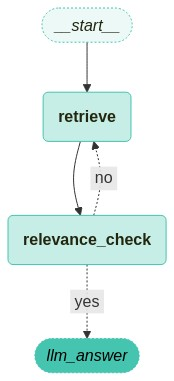

In [14]:
from langchain_teddynote.graphs import visualize_graph  

visualize_graph(app)  

### 그래프 실행

In [15]:
from langchain_core.runnables import RunnableConfig  
from langchain_teddynote.messages import stream_graph, random_uuid  

In [16]:
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})  
inputs = GraphState(question="Apple Intelligence 관련 내용을 문서에서 찾아주세요")  

stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])  


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [RELEVANCE CHECK] ====
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Apple Intelligence는 iPhone, iPad 및 Mac에서 언어와 이미지를 이해하고 생성하며, 개인 컨텍스트에서 일상적인 작업을 지원하는 기능을 제공하는 시스템입니다. 이 시스템은 사용자의 개인정보 보호를 중시하며 온디바이스 학습 방식을 채택하고 있습니다. 2024년 10월 28일에 공식 출시되었으며, 사용자는 글쓰기, 알림 및 메일 요약, 이미지에서 방해물 제거 등의 작업을 수행할 수 있습니다.

**Source**
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 10)
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 11)

In [17]:
outputs = app.get_state(config).values  

print(f'Question: {outputs["question"]}')  
print("===" * 20)  
print(f'Answer:\n{outputs["answer"]}')  

Question: Apple Intelligence 관련 내용을 문서에서 찾아주세요
Answer:
Apple Intelligence는 iPhone, iPad 및 Mac에서 언어와 이미지를 이해하고 생성하며, 개인 컨텍스트에서 일상적인 작업을 지원하는 기능을 제공하는 시스템입니다. 이 시스템은 사용자의 개인정보 보호를 중시하며 온디바이스 학습 방식을 채택하고 있습니다. 2024년 10월 28일에 공식 출시되었으며, 사용자는 글쓰기, 알림 및 메일 요약, 이미지에서 방해물 제거 등의 작업을 수행할 수 있습니다.

**Source**
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 10)
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 11)


In [18]:
from langgraph.errors import GraphRecursionError  

In [19]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})    
inputs = GraphState(question="Apple Intelligence 관련 내용을 문서에서 찾아주세요")  

# relevance_check가 실패할 경우를 대비.. 
# recursion_limit을 설정하고, 에러 처리 반영
try:  
    # 그래프 실행  
    stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])  
except GraphRecursionError as recursion_error:  
    print(f"GraphRecursionError: {recursion_error}")  


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [RELEVANCE CHECK] ====
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Apple Intelligence는 iPhone, iPad 및 Mac에서 언어와 이미지를 이해하고 생성하며, 개인 컨텍스트에서 일상적인 작업을 지원하는 기능을 제공하는 개인 인텔리전스 시스템입니다. 이 시스템은 사용자의 개인정보 보호를 중시하며 온디바이스 학습 방식을 채택하고 있습니다. 2024년 10월 28일에 공식 출시되었으며, 사용자는 글쓰기, 알림 및 메일 요약, 이미지에서 방해물 제거 등의 작업을 수행할 수 있습니다.

**Source**
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 10)
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 11)

-----
** End of Documents **